### Tectum functional analysis


The optic tectum is the primary visual processing center in the zebrafish brain. During development, new neurons are continuously added to this region. In this study, we investigate how neurons that are integrated into the visual system at different developmental stages respond to visual stimulation.

To do this, we co-expressed H2B-GCaMP6s and H2B-HaloTag in neurons by crossing elavl3:H2B-GCaMP6s fish with xla-tubb2:hsp70-ubc-H2B-HaloTag fish. We then performed CLOK dual labeling with JF552 and JF669 at 2 and 5 dpf, respectivelly. Neuronal activity was recorded at 6 dpf using two-photon calcium imaging during a series of visual stimuli.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as sc
from scipy.ndimage import gaussian_filter1d
from random import sample
import os as os
from matplotlib.patches import Rectangle

from scipy import ndimage
import warnings
warnings.filterwarnings('ignore')

from matplotlib import cm
cools = cm.get_cmap('cool_r')
icefire = cm.get_cmap('icefire')

from matplotlib.collections import LineCollection
from scipy.stats import t

from sklearn.linear_model import LinearRegression

In [8]:
def spearman(dfof, ratio, stat = True):
    if stat:
        return sc.spearmanr(dfof, ratio)[0]
    else:
        return sc.spearmanr(dfof, ratio)[1]

In [9]:
def critical_r(n, alpha=0.05, tail='two-sided'):
    """
    using student t-distribution to calculate the critical value for finding the significant threshold
    note that this function is used only to draw the threshold line on the graph, scipy calculate the threshold by itsel to determine significance
    (using the same method i believe)
    """
    df = n - 2
    if tail == 'two-sided':
        t_crit = t.ppf(1 - alpha/2, df)
    elif tail == 'one-sided':
        t_crit = t.ppf(1 - alpha, df)
    else:
        raise ValueError("tail must be 'one-sided' or 'two-sided'")
    
    r_crit = t_crit / np.sqrt(t_crit**2 + df)
    return r_crit

In [10]:
def colored_line(x, y, c, ax, **lc_kwargs):
    """
    From matplotlib's documentation
    """

    
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

In [11]:
#info about the stim protocol


"""
Brightnessof the screen at each frame
manually extracted from the visual stimulation code.
"""

op = 10 # overpass, howmany frames longer flash are displayed compared to their original length (3 frames = too short to see on the graph)
Brightness = (  #list with rgba values corresponding to the screen luminosity at the frame f
    [[1,0,0]]*177 +
    
    [[0.75,0,0]]*(3+op) + #dark flash
    [[1,0,0]]*(235-179-op) +
    [[0.5,0,0]]*(3+op) + #dark flash
    [[1,0,0]]*(294-238-op) +
    [[0.25,0,0]]*(3+op) + #dark flash
    [[1,0,0]]*(352-296-op) +
    [[0,0,0]]*(3+op) + #dark flash
    [[1,0,0]]*(410-355-op) +
    
    [[0,0,0]]*(466-410) + #long dark flash

    [[0.25,0,0]]*(3+op) + #bright flash
    [[0,0,0]]*(524-469-op) + 
    [[0.5,0,0]]*(3+op) + #bright flash
    [[0,0,0]]*(583-527-op) + 
    [[0.75,0,0]]*(3+op) + #bright flash
    [[0,0,0]]*(641-586-op) + 
    [[1,0,0]]*(3+op) + #bright flash
    [[0,0,0]]*(700-644-op) +
    
    [[1,0,0]]*(783-700) + #loongbright flash
    
    [[0.5,0,0]]*653 +


    [[0,0,0]]*(1800-1438)

)

color_moving = [0,0.6,0.6]
Brightness[839:853] = [color_moving ]*(853-839)
Brightness[908:922] = [color_moving ]*(922-908)
Brightness[978:992] = [color_moving ]*(992-978)
Brightness[1047:1061] = [color_moving ]*(1061-1047)

Brightness[1117:1131] = [color_moving ]*(1131-1117)
Brightness[1186:1200] = [color_moving ]*(1200-1186)
Brightness[1256:1269] = [color_moving ]*(1269-1256)
Brightness[1325:1339] = [color_moving ]*(1339-1325)
    
len(Brightness)

stim_starts = [
    177, 235, 295, 352, 410,
    466, 524,583, 641,700,783,
    839,908,978,1047,1117,1186,1256,1325,1438
]

In [12]:
"""
Importing the Data

There are two seperate datasets
One in which each row correspond to a neuron, and in which we have many info concerning each neurons (dye ratio, position, unique ID)
The other in which each column correspond to a neuron, labeled with the unique ID (matching the the first dataset), 
and in which we find the activity trace for the neurons.
"""

All_traces_merged = pd.read_csv("../Data/traces_tectum_example.csv")
allData_merged = pd.read_csv("../Data/data_tectum_example.csv")


0.6015376631328552 0.08917087787895984


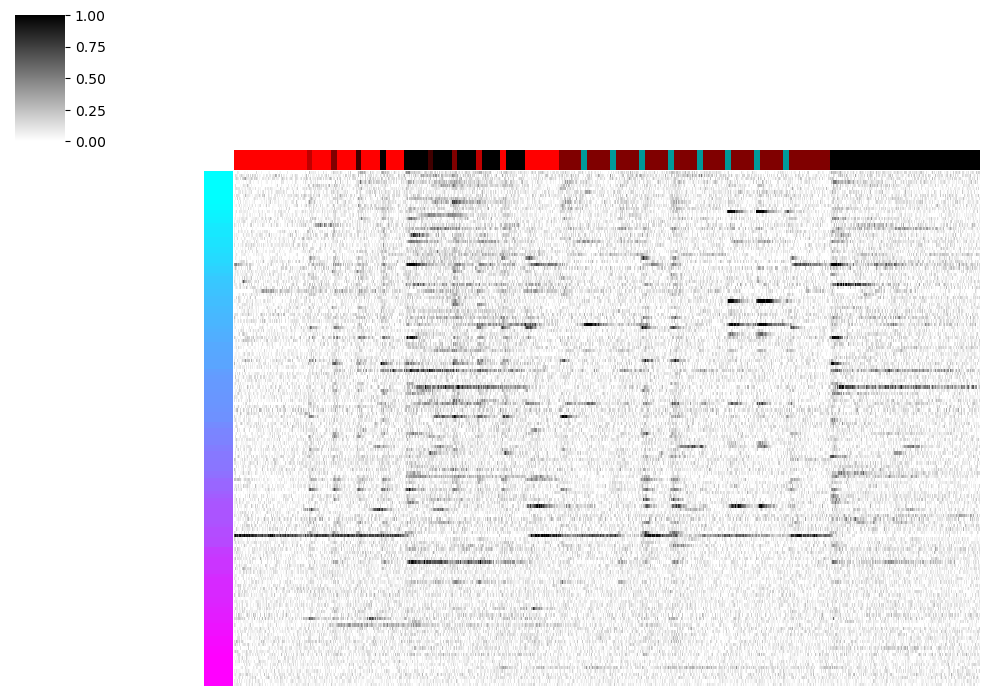

Critical r for n=156, alpha=0.05: 0.1572
0.22722222222222221


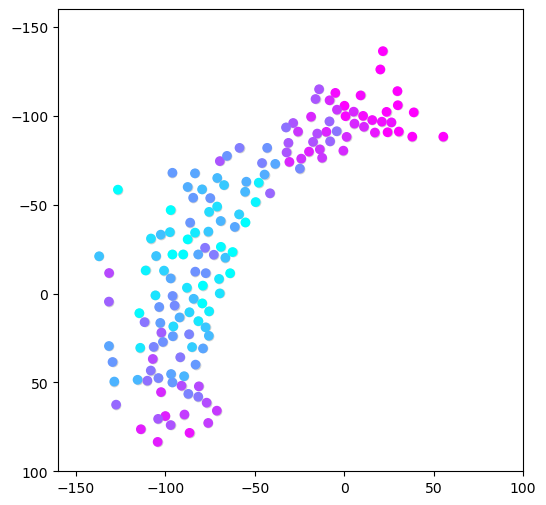

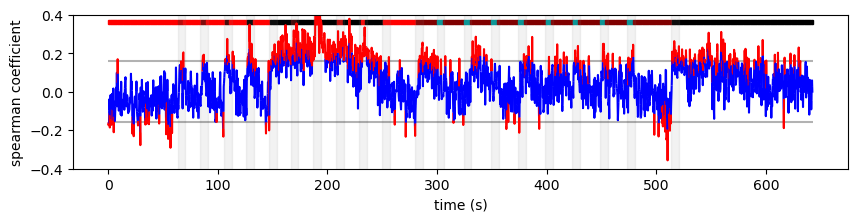

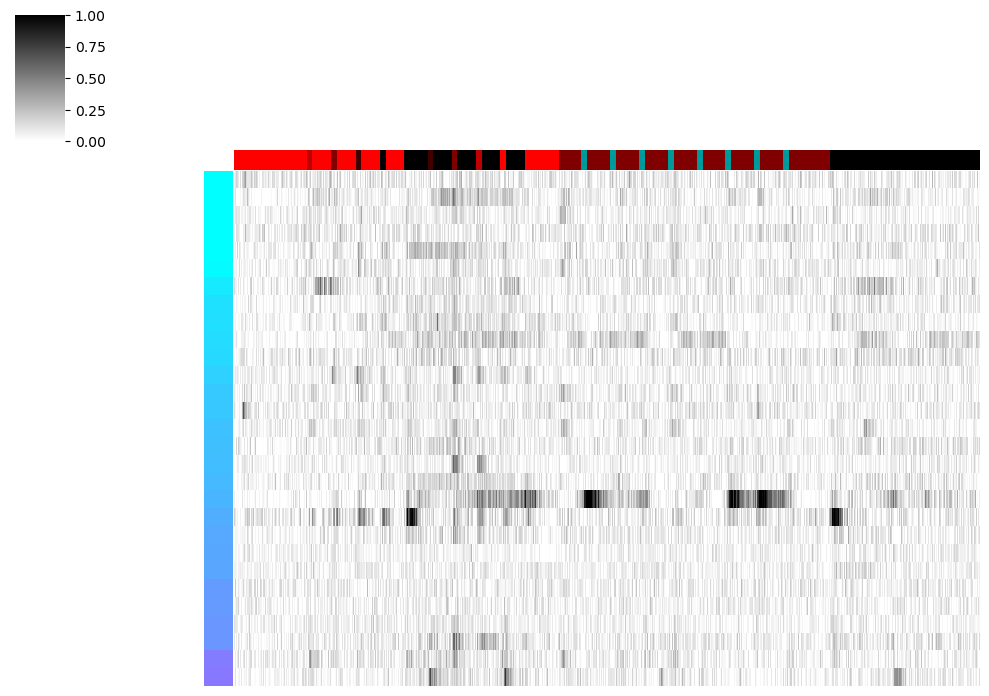

Critical r for n=29, alpha=0.05: 0.3673
0.04555555555555556


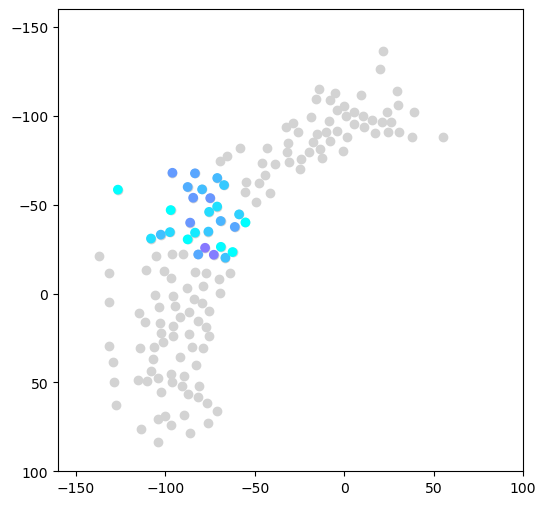

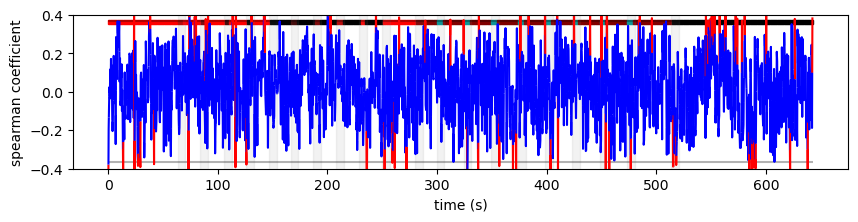

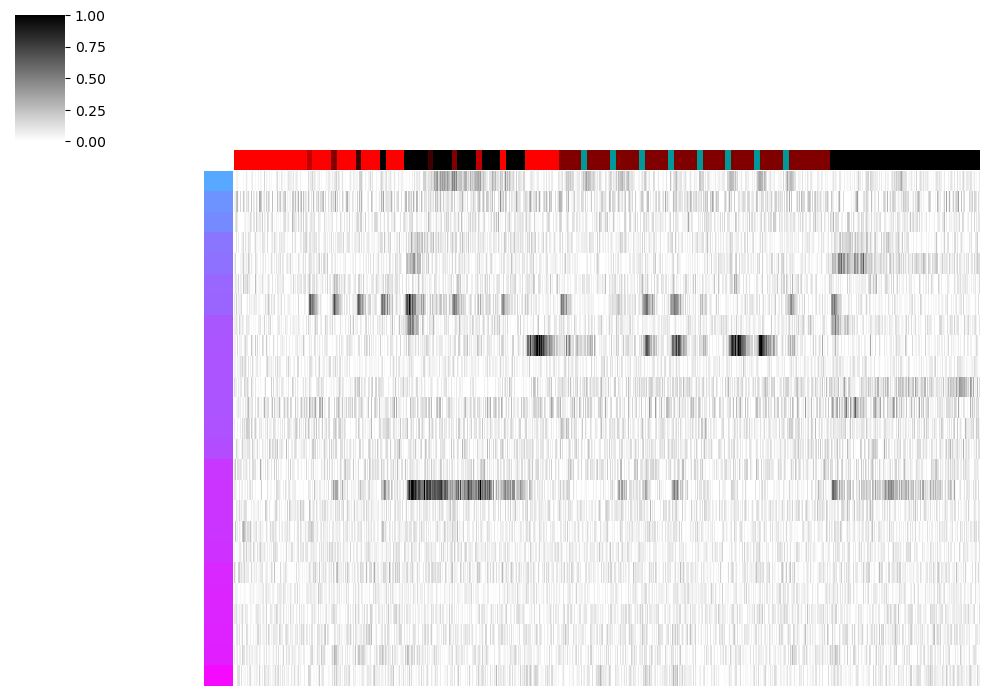

Critical r for n=25, alpha=0.05: 0.3961
0.05333333333333334


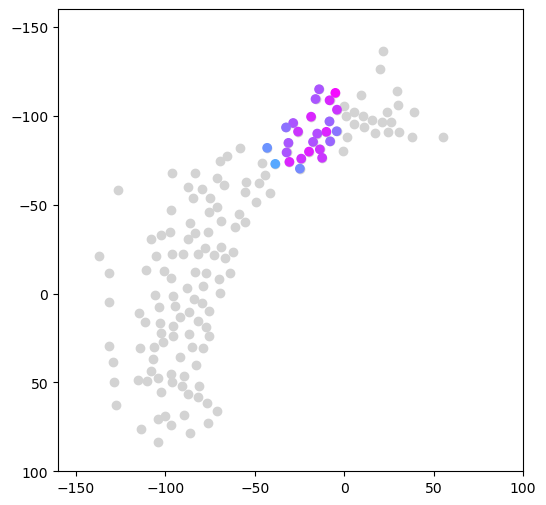

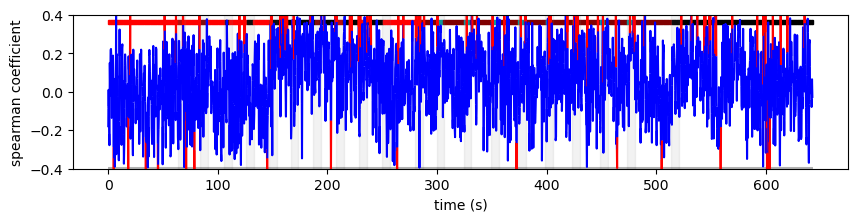

In [13]:
# clustermap of everything sorted by increasing ratio

"""
Making subsets of the data

theta is the angle of the neurons'position relative to a point in the center of the neuropil region (in radian)
so  here we take arc section of the tectum neurons
"""

V_all = allData_merged["theta"] > -1 # All neurons
V3 = (3.4<allData_merged["theta"]) & (3.9>allData_merged["theta"]) # center neurons only
#V4 = (3.5<allData_merged["theta"]) & (3.8>allData_merged["theta"]) 
V2 = (4.2<allData_merged["theta"]) & (4.7>allData_merged["theta"]) # periphery only
#V1 = (3>allData_merged["theta"]) & (2.5<allData_merged["theta"])   


color_parameter = allData_merged["ratio_Neuron"]
upper_bound = np.quantile(color_parameter, 0.95)
lower_bound = np.quantile(color_parameter,0.05)
temp_ratio = (color_parameter-lower_bound)/(upper_bound-lower_bound)

print(upper_bound, lower_bound)

for truth_serie, name in zip([V_all, V3, V2], ["all",  "center", "periphery" ]):

    Data_angle_restricted = allData_merged[truth_serie]                         #select only neurons for which the angle match
    colors = np.array([cools(value) for value in temp_ratio])[truth_serie]      #select only the colors of the neurons for which the angle match
    #-------------------------------------------------------------------------------------
    """
    clustermap, without the clusters
    neurons sorted by dye ratio
    """
    
    Plot = sns.clustermap(All_traces_merged[list(Data_angle_restricted["fish_Neuron"])].transpose(),
                          cmap = "gray_r",
                          row_colors = colors,
                          col_colors = Brightness,
                          col_cluster = False, row_cluster = False,
                          vmin=0, vmax=1,
                          yticklabels=False,xticklabels=False,
                          figsize = (10,7))
    
    plt.show()
    #----------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------
    """
    Position of cells in the neuropil
    the order is reversed to have the cyan on the top
    """
    plt.figure(figsize = (6,6))
    plt.xlim([-160,100])
    plt.ylim([-160,100])
    plt.gca().invert_yaxis()

    plt.scatter(allData_merged["X_c"], allData_merged["Y_c"], color = "lightgray")
    x_cor = list(Data_angle_restricted["X_c"])
    x_cor.reverse()
    y_cor =  list(Data_angle_restricted["Y_c"])
    y_cor.reverse()
    cor_col = list(Data_angle_restricted["ratio_Neuron"])
    cor_col.reverse()
    plt.scatter(x_cor, y_cor, c = cor_col, vmin= lower_bound, vmax = upper_bound, cmap = "cool_r")


    
    #----------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------
    #----------------------------------------------------------------------------------------------------------------------------------------------
    """
    spearmann coef plot
    for each time point, we plot the non parametric spearman coefficient, showing the correlation between the the dye ratio and the dfof
    This analysis is relevant because we do not expect a linear relationship between dye ratio and dfof (eg there might be a plateau)
    We plot the raw coefficient because it does a better job at showing the magnitude and the direction of the correlation compared with
    the p-value
    When the coef crosses the significance threshold, the plot is colored in red. note that under the null hypothesis, we still expect 
    about 5% (+/-1%) of values to be significant. (binomial confidence interval, for spearman's alpha = 0.5 and conf int's alpha = 0.5)
    We also would expect them to be distributed homogenously.

    Here there are ~42% of significant values, located around the visual stims; so the correlation between the dye ratio and the dfof is significant
    """   
    #calculating the critical value for significance
    n = len(Data_angle_restricted["fish_Neuron"])
    alpha = 0.05
    r_threshold = critical_r(n, alpha)
    print(f"Critical r for n={n}, alpha={alpha}: {r_threshold:.4f}")
    
    
    plt.figure(figsize = (10,2))
    plt.ylim(-0.4,0.4)

    #calculating the spearman coef and p-value
    spm_trace = All_traces_merged[list(Data_angle_restricted["fish_Neuron"])].apply(spearman, args = [Data_angle_restricted["ratio_Neuron"]], axis=1)
    spm_pval = All_traces_merged[list(Data_angle_restricted["fish_Neuron"])].apply(spearman, args = [Data_angle_restricted["ratio_Neuron"], False], axis=1)
    significant = spm_pval<0.05 # value for which the p-value is significant with a=0.05
    print(np.mean(significant))

    # ploting significance threshold
    plt.hlines([r_threshold, -r_threshold],0,1800, color = "black", alpha = 0.3)

    #plotting spearman coef
    fig = plt.gcf()
    ax = fig.gca()
    colored_line(range(0,1800),spm_trace,significant, ax,cmap='bwr')

    #Ploting the stim's brightness indications
    for x in range(0,1800,3):
        rec = Rectangle((x,.35), 3, 0.02, color = Brightness[x], alpha = 1)
        ax.add_patch(rec)
    diff = 20

    #ploting the timing of stiumlations
    for x in stim_starts:
        rec = Rectangle((x,-0.5), diff, 1, color = "gray", alpha = 0.1)
        ax.add_patch(rec)
    
    
    
    plt.xlabel("time (s)")
    plt.ylabel("spearman coefficient")
    timesstamps = [0, 100,200,300,400,500, 600]
    ts_position = [x*2.8 for x in timesstamps]
    plt.xticks(ts_position, timesstamps)

    plt.show()

[0, 52, 104] [51, 103, 155]
mature


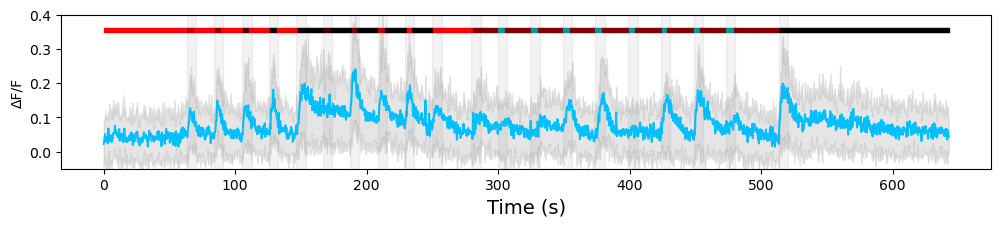

intermediate


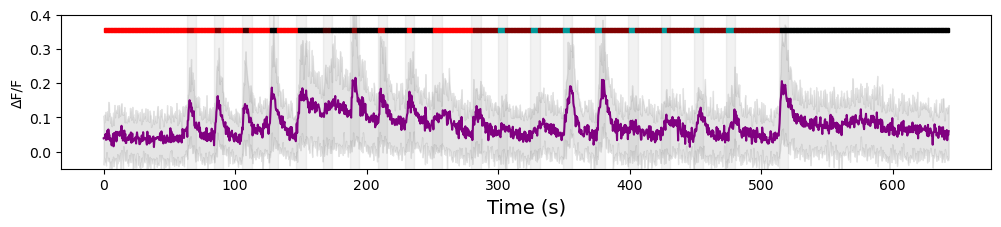

immature


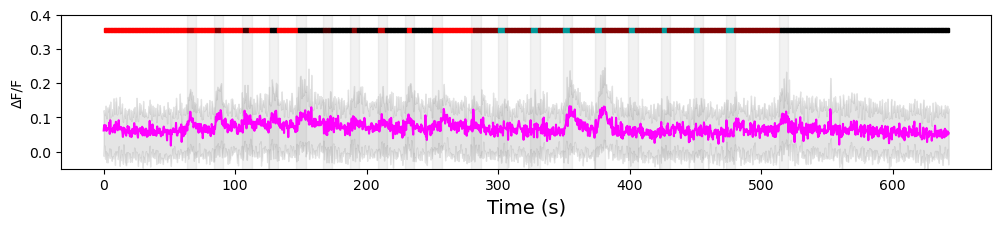

In [14]:
"""
here we seperate the neurons into three equal sized group according to their dye-ratio
and we plot the average trace for each group
"""




increment = int(np.floor(All_traces_merged.shape[1]/3))

start = [increment*x for x in range(0,round(All_traces_merged.shape[1]/increment))]
end = [increment-1+increment*x for x in range(0,round(All_traces_merged.shape[1]/increment))]
k = ["mature","intermediate",#-mature", #"intermediate-immature",
     "immature"]
color = ["deepskyblue", "purple", "magenta"]

print(start, end)

for i,j,name,colour in zip(start, end, k, color):
    plt.figure(figsize = (12,2))
    
    print(name)

    temp = All_traces_merged[list(allData_merged["fish_Neuron"])[i:j]].mean(axis = 1)
    sd = All_traces_merged[list(allData_merged["fish_Neuron"])[i:j]].std(axis = 1)
    
    plt.plot(temp,
        color = colour
    )
    
    plt.fill_between(
    range(0,1800), 
    All_traces_merged[list(allData_merged["fish_Neuron"])[i:j]].quantile(0.84, axis = 1), 
    All_traces_merged[list(allData_merged["fish_Neuron"])[i:j]].quantile(0.16, axis = 1), 
    color="gray", alpha=.2)
    
    fig = plt.gcf()
    ax = fig.gca()
    diff = 20
    for x in stim_starts:
        rec = Rectangle((x,-1), diff, 2, color = "gray", alpha = 0.1)
        ax.add_patch(rec)

    for x in range(0,1800,3):
        
        rec = Rectangle((x,.35), 3, 0.01, color = Brightness[x], alpha = 1)
        ax.add_patch(rec)

    
    plt.ylim(-0.05,0.4)
    plt.xlabel("Time (s)", size =14)
    plt.ylabel("ΔF/F")
    timesstamps = [0, 100,200,300,400,500, 600]
    ts_position = [x*2.8 for x in timesstamps]
    plt.xticks(ts_position, timesstamps)
    
    plt.show()

## Direction Selectivitiy analysis

Many neurons in the optic tectum respond to visual motion. The response is often dependant on the direction of said motion.
Here we want to see if there is correlation between the dye ratio of a neuron and its direction selectivity.

to do that, there are several steps to follow:

1. measure the response of neurons for each direction
2. select neurons that respond to at least one direction ( max df/f is higher than 4*sd in a 15 frame window )
3. calculate the direction selectivity index

To calculate the DSI, we assign to 8 vectors the direction of one of the gratings, and as magnitude the calcium response of the neuron for that grating. Then sum these vectors and normalize by the sum of the magnitudes.
The magnitude of the resulting vector is the DSI.

R2 0.063885774569295
SignificanceResult(statistic=0.2454177117499518, pvalue=0.03771987472926153)


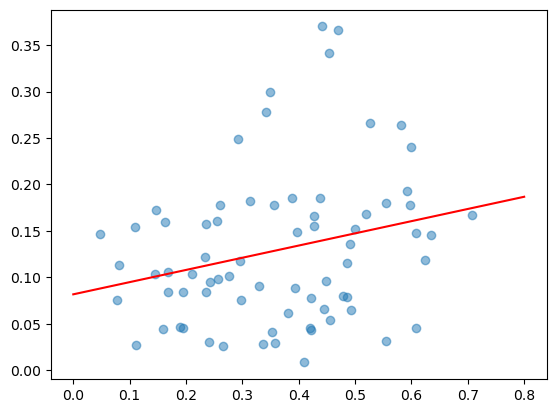

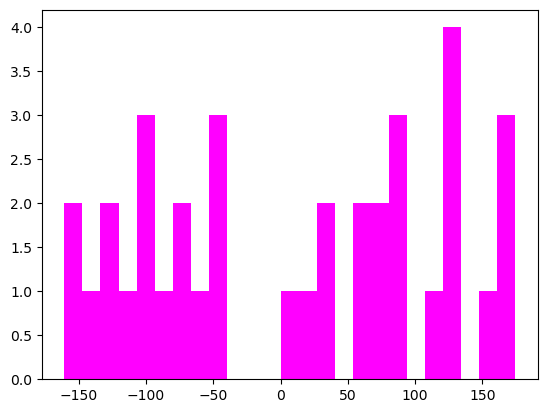

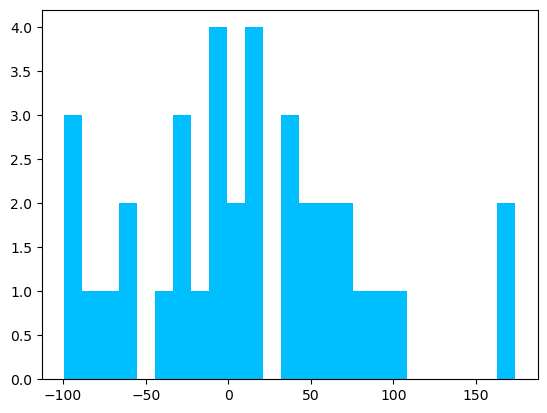

In [15]:
thresholding = "dfof"

output_data_for_merge = pd.DataFrame()

moving_bars_timings = [120, 839, 908, 978, 1047, 1117, 1186, 1256, 1325]
moving_bars_direction = ["control", "0", "180", "270", "90", "135", "315", "45", "225"]

output_data_for_merge["significant"] = [0]*allData_merged.shape[0]

#threshold = All_traces_merged.mean().mean() + 2*All_traces_merged.std().mean()
window = 15

"""
extracting the df/f for each neuron and each stim
"""

for timing, direction in zip(moving_bars_timings,moving_bars_direction):

    stat_val = []
    stat_sig = []
    for n in All_traces_merged[list(allData_merged["fish_Neuron"])]:

       
        threshold = All_traces_merged[n].iloc[timing-window:timing].mean() + 4*All_traces_merged[n].iloc[timing-window:timing].std()
    
        if All_traces_merged[n].iloc[timing:timing+window].max() > threshold:
            stat_sig.append(1)
        else: stat_sig.append(0)
        

        val = All_traces_merged[n].iloc[timing:timing+window].max()
        stat_val.append(val)

    output_data_for_merge[direction]= stat_val
    output_data_for_merge["significant"] = list(output_data_for_merge["significant"]+ np.array(stat_sig))

output_data_for_merge["ratio"] = list(allData_merged["ratio_Neuron"])

#----------------------------------------------------------------------------------------------------------------------------

"""
selecting neurons 
with at least one (1) response for a grating
"""
number_response = output_data_for_merge["significant"]
threshold_n = 1
filtered_data = output_data_for_merge[number_response>=threshold_n][["0", "180", "270", "90", "135", "315", "45", "225"]]

filtered_data.head()

# I need to convert any negative value into 0
num = filtered_data._get_numeric_data()
num[num < 0] = 0
filtered_sum= filtered_data.sum(axis = 1)

angles_deg = filtered_data.columns.astype(float)
angles_rad = np.radians(angles_deg)

x_components = (filtered_data * np.cos(angles_rad)).sum(axis=1)
y_components = (filtered_data * np.sin(angles_rad)).sum(axis=1)

filtered_data["DSI"] = np.sqrt(x_components**2 + y_components**2)
resultant_angle = np.degrees(np.arctan2(y_components, x_components))


filtered_data["ratio_Neuron"] = output_data_for_merge[number_response>=threshold_n]["ratio"]
#-------------------------------------------------------------------------

"""
plot correlation DSI ratio
"""



filtered_data["norm_DSI"] = filtered_data["DSI"]/filtered_sum

lr = LinearRegression().fit(
    np.array(filtered_data["ratio_Neuron"]).reshape(-1, 1),
    np.array(filtered_data["norm_DSI"]).reshape(-1, 1))

print("R2",lr.score(np.array(filtered_data["ratio_Neuron"]).reshape(-1, 1),
    np.array(filtered_data["norm_DSI"]).reshape(-1, 1)))

plt.scatter(filtered_data["ratio_Neuron"],filtered_data["norm_DSI"], alpha = 0.5)
print(sc.spearmanr(filtered_data["ratio_Neuron"], filtered_data["norm_DSI"]))

plt.plot(
    [0,.8],
    [(lr.intercept_[0]+lr.coef_[0]*0),(lr.intercept_[0]+lr.coef_[0]*.8)],
    color = "red"
)

plt.show()

#-------------------------------------------------------------------------
"""
plot distribution of preferred directions
"""


plt.hist(resultant_angle[filtered_data["ratio_Neuron"]<=filtered_data["ratio_Neuron"].median()],
         bins = 25, color = "magenta")

plt.show()

plt.hist(resultant_angle[filtered_data["ratio_Neuron"]>=filtered_data["ratio_Neuron"].median()],
         bins = 25, color = "deepskyblue")



plt.show()